# **Portfolio - Deep learning**

    Groepsnummer: 2
    Coach: Vikram 
    Opdrachtnummer: 1
    Namen groepsleden: 
        - Isa Dijkstra, 22119485
        - Natasja de Kok, 22059326
        - Vince Ammerlaan, 21049599
    Kaggle naam: 1 
    
    
## ***Inhoudsopgave*** <a name='begin'></a>

0. [Inleiding](#inleiding)
1. [Packages en de data inladen](#data)
2. [Opdracht 1 -EDA](#eda)
3. [Opdracht 2 - Fully connected neuraal netwerk](#CNN)
4. [Opdracht 3 - Convolutioneel neuraal netwerk from scratch](#CNNs)
5. [Opdracht 4 - Transfer learning](#tl)
6. [Opdracht 5 - Multimodaal model](#mm)
7. [Opdracht 6 - Bevindingen](#bevindingen)
8. [Opdracht 7 - Conclusie en aanbevelingen](#conclusie)
9. [Bronnenlijst](#bronnenlijst)

## Inleiding <a name='inleiding'></a>
In dit notebook proberen we verschillende deep learning-modellen uit om uiteindelijk te kijken naar welk model het beste de prijzen kan voorspellen van huizen op basis van bepaalde features. 

## Packages en de data inladen <a name='data'></a>

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.regularizers import l2
from keras.utils import plot_model
from keras.models import Sequential
from keras.regularizers import l1
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate

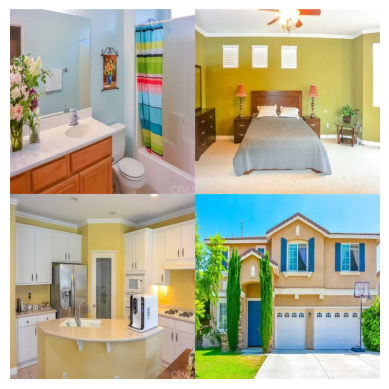

In [3]:
def load_random_image(path):
    files = os.listdir(path)
    image_files = [f for f in files if f.endswith('.png') or f.endswith('.jpg')]
    random_image_file = random.choice(image_files)
    image_path = os.path.join(path, random_image_file)
    image = mpimg.imread(image_path)
    return image

inputPath = 'Train'

image = load_random_image(inputPath)

plt.imshow(image)
plt.axis('off') 
plt.show()

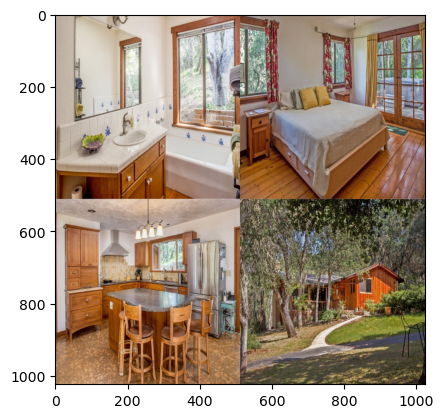

In [4]:
def load_random_image(path):
    files = os.listdir(path)
    image_files = [f for f in files if f.endswith('.png') or f.endswith('.jpg')]
    random_image_file = random.choice(image_files)
    image_path = os.path.join(path, random_image_file)
    image = Image.open(image_path)
    return image

image = load_random_image(inputPath)

plt.imshow(image)
plt.show()

In [5]:
def load_images_and_create_dataframe(directory):
    images = []
    filenames = []

    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            filepath = os.path.join(directory, filename)
            
            image = Image.open(filepath)
            image_array = np.array(image)
            images.append(image_array)
            filenames.append(filename)

    df = pd.DataFrame({'Filename': filenames, 'Image': images})
    
    df['Filename'] = df['Filename'].str.replace('.jpg', '')
    
    return df

inputPath = 'Train'
image_df = load_images_and_create_dataframe(inputPath)

C:\Users\Natasja\AppData\Local\Temp\ipykernel_2496\2535199622.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Filename'] = df['Filename'].str.replace('.jpg', '')


In [6]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [7]:
train2 = train.copy()
train2['House ID'] = train2['House ID'].astype(str)

In [8]:
test2 = test.copy()
test2['House ID'] = test2['House ID'].astype(str)

[Terug naar Inhoudsopgave](#begin)

## Opdracht 1 - EDA <a name='eda'></a>

In dit EDA onderzoeken wij de gegeven data. Wij bekijken de data oppervlakkig met de .head() functie, kijken of er ontbrekende waarden zijn en nemen wat statistieken door met behulp van .describe(). Met behulp van een histogram maken we de verdeling inzichtelijk. Om het beeld te verduidelijken voor een Nederlandse publiek hebben wij het woonoppervlak, dat initieel in square feet stond geschreven, omgezet naar vierkante meters.
Omdat wij voor  deze opdracht de koppeling van huizenprijzen aan features willen gebruiken, hebben wij voor een correlatiematrix gekozen. Deze toont ons correlaties tussen eigenschappen van huizen.
Om de beeldvorming te versterken over de features die correleren met de huizenprijs hebben wij een een scatterplot, een boxplot en een reeks aan scatterplots met lineaire verbanden die voorzichtig een trend aangeven geplot tussen de huizenprijzen en tussen featuers als het aantal badkamers en slaapkamers in een woning en het woonoppervlak. Om 


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


House ID     0
Bedrooms     0
Bathrooms    0
Area         0
Latitude     0
Longitude    0
Price        0
dtype: int64

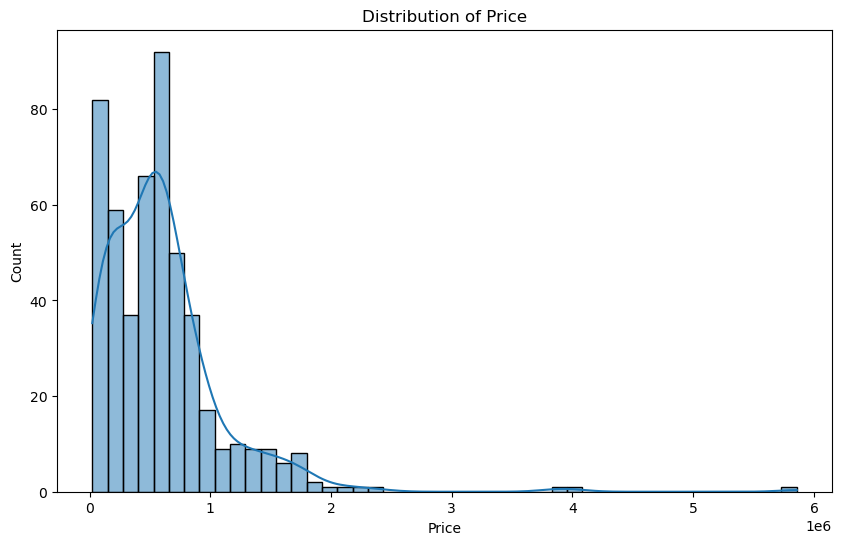

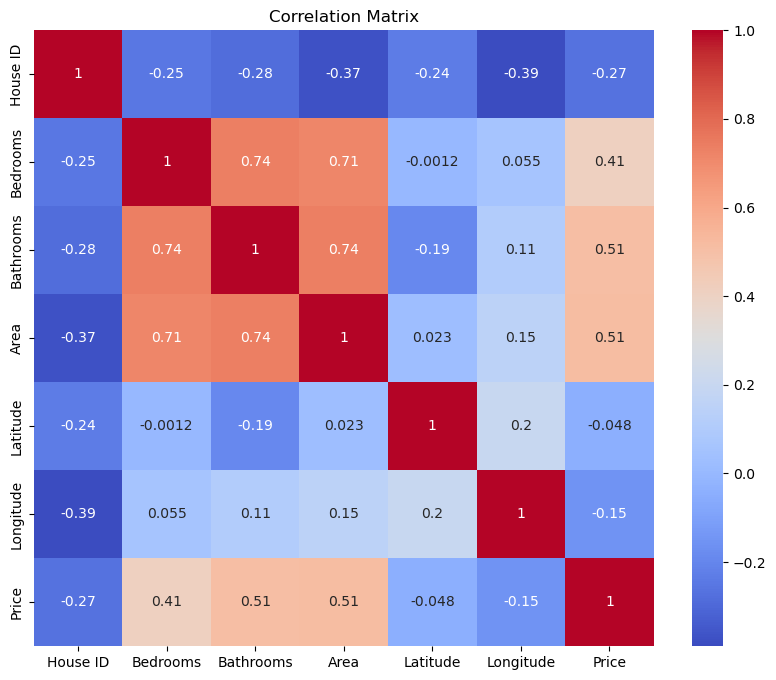

In [9]:
display(train.head())
display(train.describe())

display(train.isnull().sum())

plt.figure(figsize=(10, 6))
sns.histplot(train['Price'], kde=True)
plt.title('Distribution of Price')
plt.show()

corr = train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

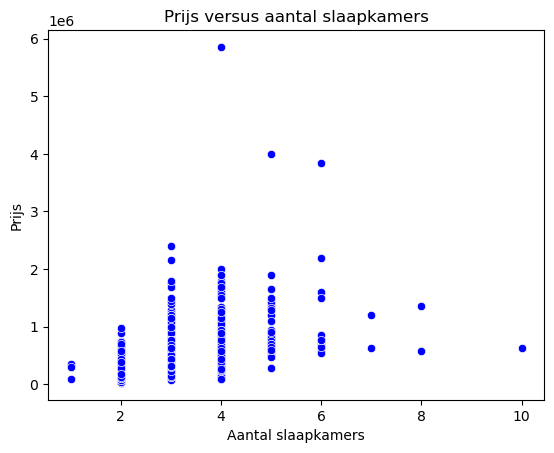

In [10]:
sns.scatterplot(data=train, x='Bedrooms', y='Price', color='blue')
plt.xlabel('Aantal slaapkamers')
plt.ylabel('Prijs')
plt.title('Prijs versus aantal slaapkamers')
plt.show()

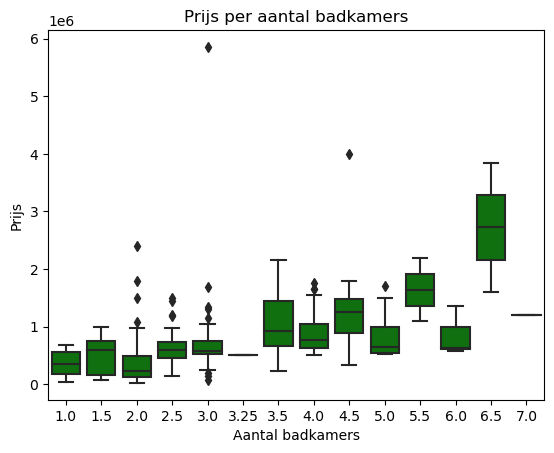

In [11]:
# Boxplot van prijs per aantal badkamers
sns.boxplot(data=train, x='Bathrooms', y='Price', color='green')
plt.xlabel('Aantal badkamers')
plt.ylabel('Prijs')
plt.title('Prijs per aantal badkamers')
plt.show()

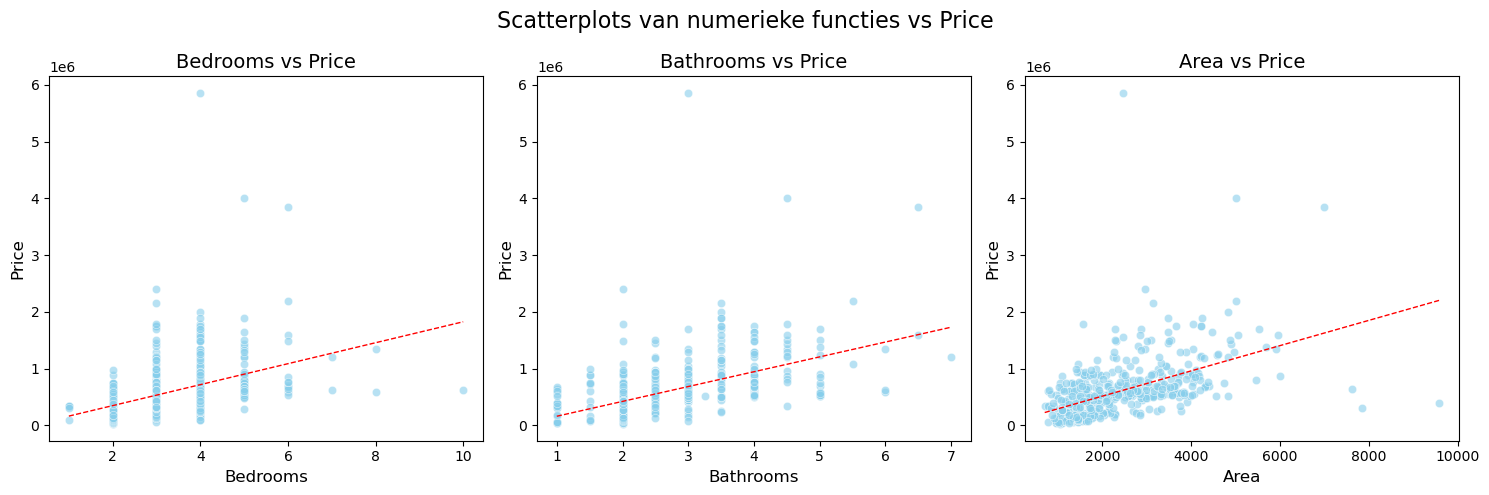

In [12]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).iloc[:, 1:-3]
num_plots = len(numeric_features.columns)
num_cols = 3
num_rows = (num_plots - 1) // num_cols + 1

plt.figure(figsize=(15, 5*num_rows))

for i, col in enumerate(numeric_features.columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.scatterplot(x=col, y='Price', data=train, color='skyblue', alpha=0.6)
    sns.regplot(x=col, y='Price', data=train, scatter=False, color='red', ci=None, line_kws={'linewidth':1, 'linestyle':'--'})
    plt.title(f"{col} vs Price", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Price", fontsize=12)

plt.suptitle("Scatterplots van numerieke functies vs Price", fontsize=16)
plt.tight_layout()
plt.show()

### Bevindingen EDA <a name='bevindingen_eda'></a>

Door middel van de EDA zijn er erachter gekomen dat we te maken hebben met een dataset waarin 500 huizen zijn opgenomen. De woningen hebben gemiddeld 3.35 slaapkamer en 2.67 badkamers per huis en een gemiddelde oppervlakte van ongeveer 220 vierkante meter. 
We zijn tijdens het EDA  uitschieters tegengekomen. Het huis met de meeste slaapkamers heeft maar liefst 10 slaapkamers, terwijl het qua oppervlak kleinste huis maar 65m^2 is. We zijn erachter gekomen dat het aantal slaapkamers niet in alle gevallen iets zegt over de prijs. In de boxplot is te zien dat het huis dat 10 slaapkamers heeft minder dan een miljoen dollar kost, terwijl er daarentegen ook een huis is met “maar” 4 badkamers dat bijna $6M kost.
Toch nemen we in onze confusion matrix, boxplot en in de scatterplots van numerieke features vs Price op deze “outliers” wel een lineaire trend waar, waarbij een groter aantal badkamers, slaapkamers en een groter woonoppervlak correspondeert met hogere huizenprijzen.


[Terug naar Inhoudsopgave](#begin)

## Opdracht 2 - Fully connected neuraal netwerk <a name='CNN'></a>

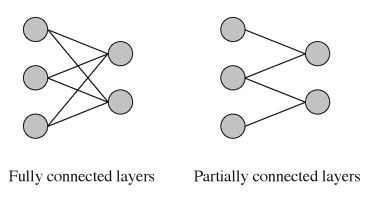

In [13]:
display(Image.open("fully connected vs partially connected.PNG"))
#Bron van het plaatje: Kiang, M.Y. (2003)

Een fully connected neuraal netwerk is een neuraal netwerk waarbij alle nodes van twee achtereenvolgende lagen met elkaar verbonden zijn. Met andere woorden: elke node geeft een output aan elke node in de direct opvolgende laag. Contrasterend daarmee is een partially connected layer, waarbij de node uit een voorgaande laag niet uit alle nodes uit de opvolgende laag verbonden is. Hieronder werken wij een fully connected neural network uit. 


### **Neuraal Netwerk**

In [14]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

features = train.drop('Price', axis=1)
target = train['Price'].astype(float)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)
num_features = features.shape[1]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mape')

history = model.fit(features_train, target_train, epochs=40, batch_size=4, validation_data=(features_test, target_test))

predictions = model.predict(features_test)

mape = mean_absolute_percentage_error(target_test, predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)

mse = mean_squared_error(target_test, predictions)
print("Mean Squared Error (MSE):", mse)

min_val_loss = min(history.history['val_loss'])
print("Laagst behaalde validatieloss:", min_val_loss)

Epoch 1/40
100/100 [==============================] - 1s 4ms/step - loss: 99.0851 - val_loss: 97.1419
Epoch 2/40
100/100 [==============================] - 0s 2ms/step - loss: 91.8650 - val_loss: 81.1762
Epoch 3/40
100/100 [==============================] - 0s 2ms/step - loss: 70.0553 - val_loss: 57.4493
Epoch 4/40
100/100 [==============================] - 0s 2ms/step - loss: 58.8708 - val_loss: 55.4088
Epoch 5/40
100/100 [==============================] - 0s 2ms/step - loss: 57.8969 - val_loss: 55.3134
Epoch 6/40
100/100 [==============================] - 0s 2ms/step - loss: 57.3716 - val_loss: 55.1351
Epoch 7/40
100/100 [==============================] - 0s 2ms/step - loss: 57.0510 - val_loss: 55.0721
Epoch 8/40
100/100 [==============================] - 0s 2ms/step - loss: 56.5722 - val_loss: 55.0452
Epoch 9/40
100/100 [==============================] - 0s 2ms/step - loss: 56.2151 - val_loss: 54.9041
Epoch 10/40
100/100 [==============================] - 0s 2ms/step - loss: 55.8723

In [15]:
image_df.head()

,Filename,Image
0,1,"[[[156, 126, 98], [164, 137, 110], [180, 154, ..."
1,10,"[[[217, 203, 174], [210, 196, 167], [202, 188,..."
2,100,"[[[159, 147, 131], [160, 148, 132], [160, 148,..."
3,101,"[[[170, 145, 105], [166, 141, 101], [174, 149,..."
4,102,"[[[170, 105, 37], [170, 105, 37], [170, 105, 3..."


### **Visualiseren**  <a name='visualisatie_val_loss_training_loss'></a>

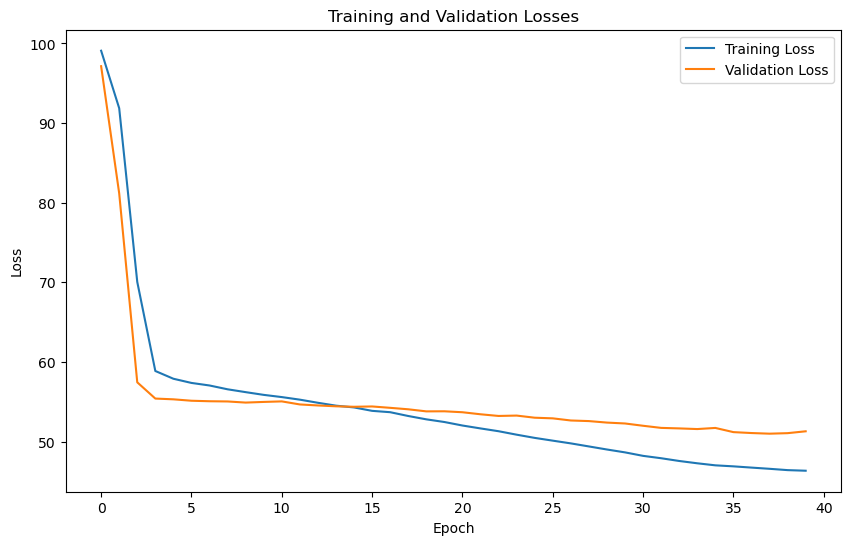

KeyError: 'accuracy'

<Figure size 1000x600 with 0 Axes>

In [16]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

### **Modelarchitectuur**

In [ ]:
#NKOK 14-3
#later weghalen, maar dit is het pad dat ik heb toegevoegd aan System in windows
#dot = graphviz.Digraph(executable='C:\\Users\\Natasja\\Documents\\arbeid2024\\AI-semester2\\Deep Learning - 2\\Github folder groepsproject DL\\Deep-Learning-Groep-2\\Portfolio opdracht 1\\Graphviz\\bin\\dot.exe')

#model.build(input_shape=(None, num_features))
#tot hier 

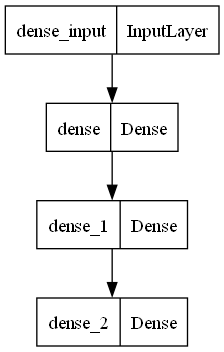

In [17]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False)

### **Keuzes onderbouwen**
- Aantal lagen en neuronen per laag:
We hebben twee hidden layers, waar ons neurale netwerk leert over de kenmerken van huizen die de prijzen beïnvloeden. Het aantal neuronen in elke laag is zo gekozen dat het netwerk complexe patronen kan begrijpen zonder te ingewikkeld te worden. We kozen in de eerste laag voor 64 neuronen voor de complexiteit van de data, waarna de 32 neuronen in de tweede laag nog verder kunnen inzoomen op bepaalde patronen. 

-Batchgrootte
De batchgrootte, of batch size, wil het aantal datapunten dat per keer door een network wordt gestuurd tijdens één epoch, opdat uiteindelijk alle data tijdens de epoch door het netwerk is gestuurd. (deeplizard. (2017, November 23). ). We hebben eerst een batch size van 32 gekozen, wat relatief groot is in vergelijking met het totale aantal datapunten van 500. Een grotere batchgrootte zoals dit kan voordelen bieden, zoals dat ook op computers die wat minder krachtig zijn sneller kan runnen. Aan de andere kant kan er overfitting optreden, omdat het model tijdens de training telkens dezelfde datapunten ziet. We hebben daarnaast  kleine batch-sizes uitgeprobeerd, zoals een batch size van 1, van 4 en van 8. Batchgrootte 1 en 4 kregen een betere MAPE-score (ongeveer 0.51) dan bij batchgrootte 8 werd bereikt (0.52). Bij een batch-size van 1 is er een gevaar van overfitten, omdat de kans is dat ruis, dus de eigenaardigheden van het specifieke geval worden geleerd in plaats van patronen,  dus daar hebben we niet voor gekozen. 

- Activeringsfuncties:
We gebruiken activatiefunctie ReLU in ons netwerk. ReLU staat voor "rectified linear unit". ReLU voegt non-lineariteit toe aan ons model. Het zorgt ervoor dat een neuron niet wordt geactiveerd als de vermenigvuldiging van het gewicht van een neuron, het inputsignaal plus de bias niet positief is. 

$$
f(x) = \begin{cases} 
0 & \text{als } x < 0 \\
x \cdot w + b & \text{als } x \geq 0 
\end{cases}
$$


Het blijft een fully connected model, alleen worden er een aantal neuronen niet meer geactiveerd door de ReLU-functie. Daardoor kan de input van de neuronen die wel worden geactiveerd sterker meetellen (Krishnamurthy, B. (2024, February 26).). Want de neuronen waarbij een positieve uitkomst wordt behaald worden wel geactiveerd. Hieronder volgt een voorbeeld van een grafiek van een ReLU-functie. Te zien is dat bij negatieve x-waarden de y-waarde steeds 0 is en pas vanaf 0 de y-waarde begint te stijgen.



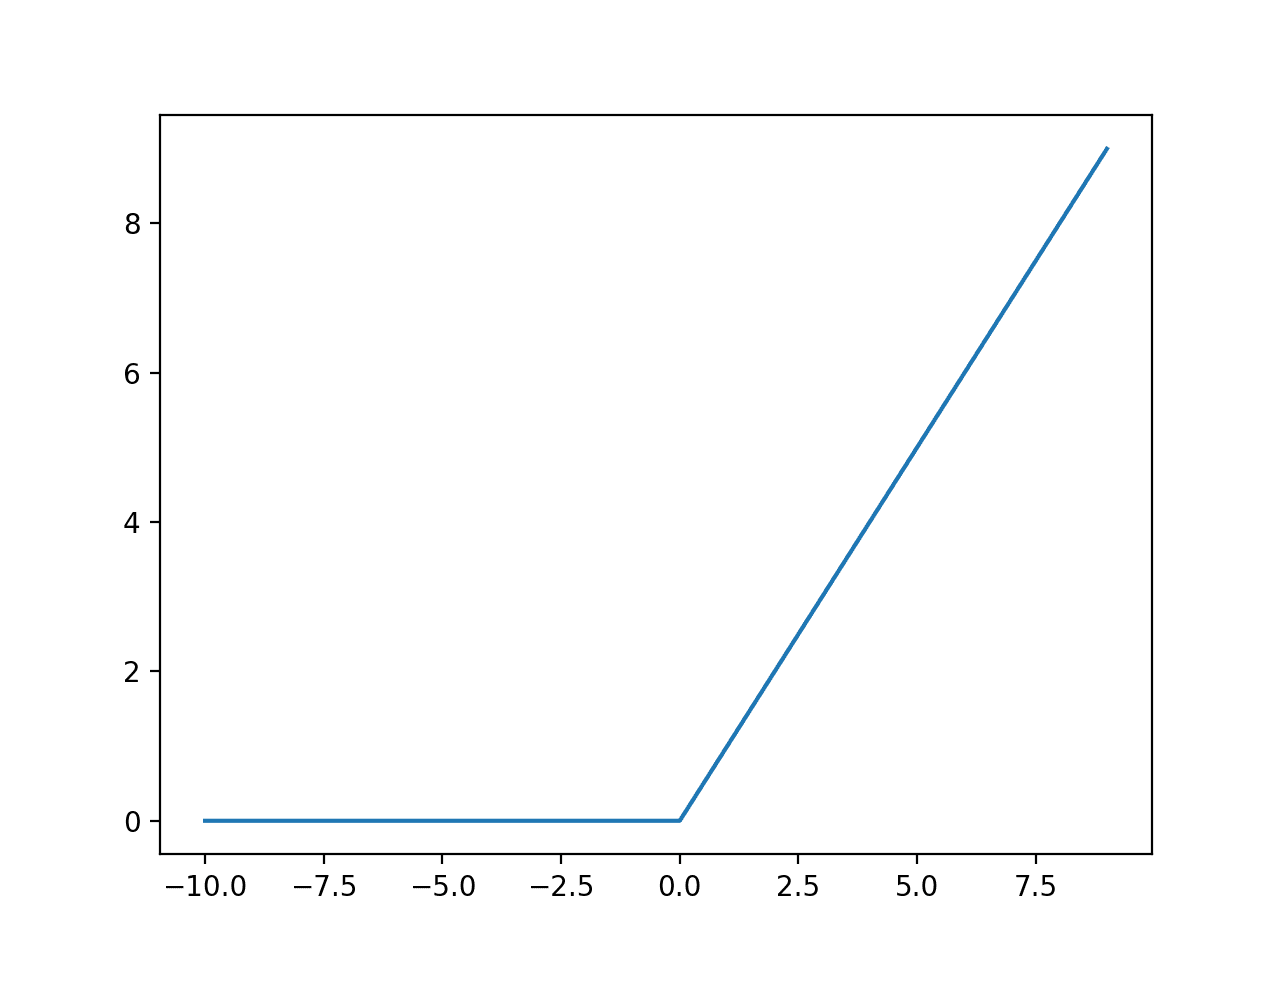

In [18]:
display(Image.open("ReLU.PNG"))

#Bron van het plaatje: Brownlee, J. (2020, August 20).

- Optimizer:
De "optimizer" helpt ons netwerk om te leren van de gegevens. We gebruiken een populaire keuze genaamd Adam, die zich aanpast aan de gegevens terwijl het leert.

-  Aantal Epochs
Door te kijken hoe de trainings- en validatieloss veranderen tijdens de trainingsperiode, kunnen we een moment vinden om te stoppen met trainen, om overfitting te vermijden. Zoals te zien is in de visualisatie nemen de trainings- en validationloss snel af en zien ze er vrij vlak uit na 40 epochs. 
Daarom is volgens ons 40 epochs een goed moment om te stoppen met trainen. Wij hebben het model op nog veel meer epochs getest. Maar bij 50.000 epochs kwamen er geen betere resultaten uit en daarom hebben we het op 40 epochs gehouden.

### **Welke lossfunctie**

Voor het voorspellen van huizenprijzen is de Mean Absolute Percentage Error (MAPE) een goede lossfunctie. Deze lossfunctie meet immers het gemiddelde percentage waarmee de voorspellingen afwijken van de werkelijke waarden. Het is bovendien een handige metric voor regressieproblemen zoals huizenprijsvoorspellingen omdat het de nauwkeurigheid van de voorspellingen weergeeft en daarbij ook kijkt naar hoe groot het verschil is ten opzichte van de huizenprijzen.

Adam is een slim algoritme dat helpt bij het trainen van neurale netwerken, zoals ons model om huizenprijzen te voorspellen. Het werkt als volgt:

- Adaptieve leersnelheid: Adam past de leersnelheid (hoe snel het model leert van de gegevens) aan voor elk gewicht in het netwerk. Als sommige kenmerken van de gegevens moeilijker zijn om te leren, zal Adam automatisch de leersnelheid voor die kenmerken verlagen, zodat het model ze beter kan begrijpen.

- Momentum: Het houdt ook rekening met de richting van de vorige updates tijdens het trainen. Als het model eenmaal in een bepaalde richting is gegaan om de lossfunctie te verbeteren, zal Adam die richting onthouden en sneller vooruit gaan in die richting. Dit helpt om sneller te convergeren naar een goed punt waar de voorspellingen nauwkeurig zijn.

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mape')
model.fit(features_train, target_train, epochs=40, batch_size=32, validation_data=(features_test, target_test))
predictions = model.predict(features_test)

mape = mean_absolute_percentage_error(target_test, predictions)
print("Mean Absolute Percentage Error:", mape)

Epoch 1/40
13/13 [==============================] - 1s 18ms/step - loss: 100.5976 - val_loss: 100.4666
Epoch 2/40
13/13 [==============================] - 0s 5ms/step - loss: 100.4293 - val_loss: 100.3150
Epoch 3/40
13/13 [==============================] - 0s 6ms/step - loss: 100.2822 - val_loss: 100.1523
Epoch 4/40
13/13 [==============================] - 0s 5ms/step - loss: 100.0979 - val_loss: 99.9513
Epoch 5/40
13/13 [==============================] - 0s 5ms/step - loss: 99.8889 - val_loss: 99.7002
Epoch 6/40
13/13 [==============================] - 0s 5ms/step - loss: 99.6244 - val_loss: 99.3721
Epoch 7/40
13/13 [==============================] - 0s 5ms/step - loss: 99.2379 - val_loss: 98.9288
Epoch 8/40
13/13 [==============================] - 0s 5ms/step - loss: 98.8226 - val_loss: 98.3294
Epoch 9/40
13/13 [==============================] - 0s 5ms/step - loss: 98.1150 - val_loss: 97.5225
Epoch 10/40
13/13 [==============================] - 0s 5ms/step - loss: 97.4973 - val_loss:

In [20]:
# Om het naar kaggle te uploaden

y_pred = model.predict(test)
y_pred = np.squeeze(y_pred)

test_predictions_df = pd.DataFrame(
        {'House ID': test['House ID'],
        'Price': y_pred})

#test_predictions_df.to_csv(
#        'Kaggle Submissions/{naam_bestand}.csv',
#       index=False)

2/2 [==============================] - 0s 3ms/step


### Bevindingen fully connected neural network <a name='bevindingen_fcnn'></a>
Met een simpel fully connected neural network met een ReLU-activation function, leersnelheidalgoritme adam, 40 epochs en andere door ons gekozen metrieken hebben wij een prestatie gehaald van een MAPE van ongeveer 0.5. Op een schaal van 0 tot 100% zien wij dat als een uitstekende score. Echter is de Mean Absolute Error een hoog getal, wat duidt op een mindere prestatie. 

Mean Absolute Percentage Error (MAPE): 0.5129913831951604
Mean Squared Error (MSE): 152479325818.97852
Laagst behaalde validatieloss: 50.999576568603516


[Terug naar Inhoudsopgave](#begin)

## Opdracht 3 - Convolutioneel neuraal netwerk from scratch <a name='CNNs'></a>
Een CNN kenmerkt zich door convolutie, oftewel het gebruik van een kernel dat over een afbeelding beweegt, waarbij kenmerken kunnen worden gedetecteerd. In de simpelere lagen worden dingen als lijnen erkend en in de hogere lagen worden steeds abstractere details herkend. Een CNN moet worden afgestemd op hetgeen waarop het wordt toegepast. In het geval van onze portfolio-opdracht wordt de CNN toegepast op gedetailleerde en gevarieerde foto's om de huizenprijzen te kunnen voorspellen. Er is dus nodig dat er meer details worden herkend. 


### **Onderbouwing keuzes**
Onderbouw je keuzes van het aantal convolutionele lagen, poollagen, convolutionele kernels per laag, het aantal fully-connected lagen en het aantal neuronen per laag.

-Lagen: Dit CNN bestaat uit 3 lagen. We hebben het aantal lagen verminderd van 4 naar 3 naar 2, omdat het beter bleek te presteren qua val loss met 2 lagen. Wellicht kan dat worden verklaard omdat we relatief weinig data ter beschikking hebben.

-Filters en neuronen: bij een complexere taak kunnen veel lagen en neuronen te pas komen. We hebben hier voor Het aantal neuronen kan niet worden gekozen door ons, maar dat wordt automatisch gekozen door de Conv2D-lagen zelf. Een Conv2D-laag voert een convolutie uit op bestanden met meerdere kanalen, zoals onze RGB-afbeelding die uit 3 kanalen bestaan. We kiezen voor een ruime hoeveelheid filters om complexe abstracte patronen vast te leggen. We laten het aantal filters toenemen per laag, voor steeds meer complexiteit, maar laten dat aantal weer iets zakken voordat de input aankomt bij de Flatten-laag. 


-We hebben ook voor de CNN ADAM gekozen. Dit is een optimizer die simpel is in het gebruik, makkelijk af te stemmen is en snel convergeert.(Madhugiri, D. (2023, April 6)). Voor meer uitleg over ADAM verwijs ik naar het vorige hoofdstuk. 

-We hebben voor loss fucntion ReLU gekozen. Voor meer informatie over ReLU verwijzen we naar het vorige hoofdstuk. 

-We hebben een dropout rate uitgeprobeerd met een rate van 0.5, 0.2 en 0.1. Maar het model presteerde qua validation loss beter zonder dropout rate. We denken dat de Dropout rate, waarbij op willekeurige wijze nodes worden uitgezet, de regularisering, waarbij op gecontroleerde wijze nodes worden verlaagd of uitgezet, verstoort. 

-We hebben gekozen voor L1, dus de regularisering waarbij nodes uit kunnen worden gezet, omdat L1 betere resultaten gaf dan L2, waarbij de output van nodes slechts wordt verkleind. 

-We gebruiken BatchNormalization om weer wat snelheid in de training van het model te krijgen. Door de normaliserering van de invoerwaarden in het model, waarbij het gemiddelde nul is en de variantie één, zorgt voor voorspelbaarheid en consistentie in het updaten van de modelparameters (Wikipedia contributors. (2022, March 28).).

Ja, normaliseren betekent inderdaad het gelijk maken van de invoer. In het geval van batch normalization wordt de invoer van elke laag gecentreerd en geschaald, zodat het gemiddelde nul is en de variantie één, wat helpt bij het stabiliseren en versnellen van het trainingsproces van neurale netwerken.

-Data augmentation betekent het veranderen van de data met als doel de data diverser te maken en / of de hoeveelheid data te vergroten. Daarbij kun je denken aan de kleuren veranderen, de afbeelding spiegelen, vergroten, verkleinen, schuin maken en verschuiven. Omdat er naar kenmerken op foto's wordt gekeken en alle foto's redelijk recht lijken te zijn, lijken horizontaal spiegelen mij nuttig, evenals het feller maken of anderzijds veranderen van de helderheid van de foto's nuttig, omdat de lichtinval nogal kan verschillen per foto. 
Hieronder passen we de foto's aan met verschillende vormen van augmentation. Of een bepaalde augmentation wordt toegepast wordt bepaald door een willekeurige kans van 50%. Tijdens de data augmentatie worden de nieuwe datapunten toegevoegd aan de set waarmee daarna getraind kan worden. We hebben num_iterations op 2 gezet, wat resulteerde in 64 datapunten, waardoor het model een lagere val loss kreeg dan wanneer num_iterations 1 was (48 datapunten).

### **Welke loss functie - CNN**
MSE (Mean Square Error) is een veelgebruikte loss functie bij CNNs. De MSE heeft een aantal voordelen:

-Het is makkelijk te lezen. Een lage waarde geeft aan dat de voorspellingen dichtbij de echte waarden liggen. 

-Het is gevoelig voor fouten, omdat fouten worden uitvergroot door de kwadratiseren.

-Een MSE presteert doorgaans goed als het een minimum heeft bereikt. 

(Gupta, S. (2023, June 30)).

3. Gebruik een of meer van de volgende technieken in je model. Beschrijf en motiveer je keuze:

- L1 regularisatie
- L2 regularisatie
- Dropout
- Batchnorm



4.	Beschrijf welke vormen van data augmentation (indien van toepassing ) geschikt zijn voor dit probleem. Implementeer dit in je datapijplijn.




Bron:https://stackoverflow.com/questions/273946/how-do-i-resize-an-image-using-pil-and-maintain-its-aspect-ratio

Bron: https://pillow.readthedocs.io/en/stable/reference/Image.html

Laad afbeeldingen in een map, negeert automatisch gegenereerde labels van de map, extraheert de bestandspaden en koppelt de ID's van de bestanden aan de bijbehorende labels. 

In [21]:
#Dubbel! 28 maart hier neergezet, zodat ik het kon gebruiken voor de CNN - NKOK
image_size = (224, 224)
batch_size = 32

# This loads the images but ignores the labels
image_dataset = tf.keras.utils.image_dataset_from_directory(
    'Train',
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size)

# Extract file paths from the dataset
image_file_paths = image_dataset.file_paths

# Extract only file ID without extension from file paths
image_uuids = [Path(image_file_path).stem for image_file_path in image_file_paths]

# Map each file path to its label using the DataFrame
# Ensure the uuids in the DataFrame exactly match those in `image_uuids`
labels = [train2.loc[train2['House ID'] == uuid, 'Price'].values[0] / 100000 for uuid in image_uuids]

# Convert the list of labels into a TensorFlow dataset
labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)

# Combine the original image dataset with the labels dataset
final_dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

Found 500 files belonging to 1 classes.


In [22]:
num_samples = final_dataset.cardinality().numpy()
print("Aantal datapunten in final_dataset:", num_samples)


Aantal datapunten in final_dataset: 16


In [53]:
import tensorflow as tf

tf.random.set_seed(42)

def augment_data(image, label):
    if tf.random.uniform(()) > 0.5:
        augmented_image = tf.image.flip_left_right(image)
    else:
        augmented_image = image
    
    if tf.random.uniform(()) > 0.5:
        augmented_image = tf.image.flip_up_down(augmented_image)
    
    if tf.random.uniform(()) > 0.5:
        augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.2)
    
    if tf.random.uniform(()) > 0.5:
        augmented_image = tf.image.random_contrast(augmented_image, lower=0.5, upper=1.5)
    
    if tf.random.uniform(()) > 0.5:
        augmented_image = tf.image.random_hue(augmented_image, max_delta=0.2)
    
    if tf.random.uniform(()) > 0.5:
        augmented_image = tf.image.random_saturation(augmented_image, lower=0.5, upper=1.5)
    
    return augmented_image, label

augmented_dataset = final_dataset.map(augment_data)

combined_dataset = final_dataset.concatenate(augmented_dataset)

num_iterations = 2  
for _ in range(num_iterations):
    augmented_dataset = final_dataset.map(augment_data)
    combined_dataset = combined_dataset.concatenate(augmented_dataset)

num_samples_combined = combined_dataset.cardinality().numpy()
print("Aantal datapunten in dataset:", num_samples_combined)

TypeError: in user code:

    File "C:\Users\Natasja\AppData\Local\Temp\ipykernel_2496\3964290328.py", line 7, in augment_data  *
        augmented_image = tf.image.flip_left_right(image)

    TypeError: Cannot convert a list containing a tensor of dtype <dtype: 'float64'> to <dtype: 'float32'> (Tensor is: <tf.Tensor 'args_1:0' shape=(None, 5) dtype=float64>)


In [29]:
train_dataset = final_dataset.take(12) 
val_dataset = final_dataset.skip(12) 

In [26]:
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l1'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l1'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

cnn_model = build_cnn_model(input_shape=(image_size[0], image_size[1], 3))
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
epochs = 10

history = cnn_model.fit(combined_dataset, epochs=epochs, validation_data=val_dataset)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot de trainings- en validatieloss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

min_val_loss = min(history.history['val_loss'])
print("Laagst behaalde validatieloss:", min_val_loss)

# Bereken en print de Mean Squared Error (MSE)
mse = cnn_model.evaluate(val_dataset)
print("Mean Squared Error (MSE):", mse)


Epoch 1/10
64/64 [==============================] - 234s 4s/step - loss: 4992.3804 - val_loss: 651.3210
Epoch 2/10
64/64 [==============================] - 232s 4s/step - loss: 530.7753 - val_loss: 220.5642
Epoch 3/10
64/64 [==============================] - 228s 4s/step - loss: 327.4266 - val_loss: 109.9741
Epoch 4/10
64/64 [==============================] - 226s 4s/step - loss: 183.6015 - val_loss: 145.4266
Epoch 5/10
64/64 [==============================] - 226s 4s/step - loss: 177.8286 - val_loss: 78.8311
Epoch 6/10
64/64 [==============================] - 226s 4s/step - loss: 112.9160 - val_loss: 115.7820
Epoch 7/10
64/64 [==============================] - 226s 4s/step - loss: 96.1510 - val_loss: 63.2555
Epoch 8/10
64/64 [==============================] - 231s 4s/step - loss: 101.4236 - val_loss: 68.7640
Epoch 9/10
64/64 [==============================] - 238s 4s/step - loss: 134.0570 - val_loss: 70.3438
Epoch 10/10
49/64 [=====================>........] - ETA: 54s - loss: 77.6230

KeyboardInterrupt: 

In [24]:
tf.keras.utils.plot_model(
    cnn_model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False)

NameError: name 'cnn_model' is not defined

### Bevindingen convolutional neural network <a name='bevindingen_cnn'></a>
TODO: Gewoon het model runnen. Dan komt er het volgende uit:
De Mean Squared Error was: <vul in>
De laagste validation loss was: <vul in>

[Terug naar Inhoudsopgave](#begin)

## Opdracht 4 - Transfer learning <a name='tl'></a>

Transfer learning is een vorm van machine learning waarbij van tevoren getrainede modellen worden ingezet en aangepast ten behoeve van nieuwe taken. Deze vooraf getrainde modellen worden pretrained models genoemd. 


### Uitleg gemaakte keuzes

In de transfer learning-code komen een aantal hyperparameters terug. De leersnelheid van 0.005 geeft aan dat er kleine stappen worden genomen richting het minimum. Hiermee voorkom je dat je over een minimum heenstapt. Wat wel een risico is met zo'n kleine leersnelheid is dat je in een lokaal minimum terecht kan komen. Echter zijn de resultaten redelijk goed, dus we hebben gekozen om deze leersnelheid aangehouden.

-Verder hebben we gekozen voor 20 epochs. Dit gaf ons resultaten waarbij de val loss redelijk laag -werd, ondanks dat we niet zeker weten of we hiermee  het minimum of een lokaal minimum hebben genaderd.  

-Een dropout rate van 0.25 hebben we ingevoerd om ervoor te zorgen dat er wat meer willekeurigheid wordt ingebouwd en daarbij een robuuster en minder overfitting model zal worden gebouwd, omdat 25% van de neuronen erbij op basis van een randomnization zal worden gedeactiveerd. 


In [ ]:
# #28 maart 2024 dubbel NKOK, naar hoofdstuk 3 CNN verplaatst
# # Load images without considering the directory-generated labels
# image_size = (224, 224)
# batch_size = 32

# # This loads the images but ignores the labels
# image_dataset = tf.keras.utils.image_dataset_from_directory(
#     'Train',
#     label_mode=None,
#     image_size=image_size,
#     batch_size=batch_size)

# image_file_paths = image_dataset.file_paths

# # Extract only file ID without extension from file paths
# image_uuids = [Path(image_file_path).stem for image_file_path in image_file_paths]

# # Map each file path to its label using the DataFrame
# # Ensure the uuids in the DataFrame exactly match those in `image_uuids`
# labels = [train2.loc[train2['House ID'] == uuid, 'Price'].values[0] / 100000 for uuid in image_uuids]

# # Convert the list of labels into a TensorFlow dataset
# labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)

# # Combine the original image dataset with the labels dataset
# final_dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

In [31]:
#test data inladen
test_image_dataset = tf.keras.utils.image_dataset_from_directory(
    'Test',
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size
)

Found 35 files belonging to 1 classes.


In [32]:
num_batches_train = len(list(final_dataset))
print("Number of batches in final_train_dataset:", num_batches_train)

Number of batches in final_train_dataset: 16


In [33]:
##28 maart 2024 dubbel NKOK, naar hoofdstuk 3 CNN verplaatst
train_dataset = final_dataset.take(12) 
val_dataset = final_dataset.skip(12) 

In [34]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(5).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
batch_size = 32
img_height = 224
img_width = 224

In [37]:
#del(model_xfer)
#MOET DEZE WEG?

resnet50_model = tf.keras.applications.resnet50.ResNet50(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the model
resnet50_model.trainable = False

# Get the preprocessing function for the ResNet50 model
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Convert this function into a Keras layer using tf.keras.layers.Lambda()
preprocessing_layer = layers.Lambda(preprocess_input)

# Build and train the model.
# Make sure to use a Flatten() or a GlobalAveragePooling2D() layer after the feature extraction layers to give a 1D input for the dense layers

model_xfer = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    preprocessing_layer,
    resnet50_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(1)
])

base_learning_rate = 0.005
model_xfer.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
              loss='mape')

initial_epochs = 20
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# Train the model
history = model_xfer.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs, callbacks=[stop_early])

mse = model_xfer.evaluate(val_dataset)
print("Mean Squared Error (MSE):", mse)

min_val_loss = min(history.history['val_loss'])
print("Laagst behaalde validatieloss:", min_val_loss)


Epoch 1/20
 3/12 [======>.......................] - ETA: 16s - loss: 82.3343

KeyboardInterrupt: 

In [ ]:
plot_loss(history)

### Stappen transfer learning model

In de codecell hieronder worden de meest kenmerkende stappen van het transfer learning model doorlopen. Dat zijn de volgende stappen:
- Een model wordt uitgekozen. In dit geval is dat het ResNet50-model met gewichten die zijn getraind met behulp van een dataset die "imagenet" heet. 
-De gewichten worden bevroren bij de regel resnet5-_model.trainable = False. Hiermee wordt er voor gezorgd dat de voorgetrainde gewichten blijven zoals ze zijn.
-Het voorgeladen model krijgt nieuwe lagen bij het codeblok model_fer = tf.keras.Sequential([....].



In [38]:
resnet50_model = tf.keras.applications.resnet50.ResNet50(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

resnet50_model.trainable = False

preprocess_input = tf.keras.applications.resnet50.preprocess_input

preprocessing_layer = layers.Lambda(preprocess_input)

model_fer = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    preprocessing_layer,
    resnet50_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(1)
])

base_learning_rate = 0.0005
model_fer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='mape')

initial_epochs = 20
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

history = model_fer.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs, callbacks=[stop_early])

Epoch 1/20
12/12 [==============================] - 34s 3s/step - loss: 94.4623 - val_loss: 71.1810
Epoch 2/20
12/12 [==============================] - 30s 3s/step - loss: 76.2198 - val_loss: 69.0302
Epoch 3/20
12/12 [==============================] - 30s 3s/step - loss: 73.1335 - val_loss: 69.6801
Epoch 4/20
12/12 [==============================] - 30s 3s/step - loss: 72.9557 - val_loss: 69.6075
Epoch 5/20
12/12 [==============================] - 30s 3s/step - loss: 73.2209 - val_loss: 69.1842
Epoch 6/20
12/12 [==============================] - 30s 3s/step - loss: 72.0991 - val_loss: 69.0131
Epoch 7/20
12/12 [==============================] - 30s 3s/step - loss: 74.0397 - val_loss: 69.4718
Epoch 8/20
12/12 [==============================] - 29s 3s/step - loss: 72.9487 - val_loss: 69.4238
Epoch 9/20
12/12 [==============================] - 29s 3s/step - loss: 72.2576 - val_loss: 68.9911
Epoch 10/20
12/12 [==============================] - 30s 3s/step - loss: 72.6407 - val_loss: 69.0403

In [ ]:
plot_loss(history)

In [39]:
model1 = Sequential()
model1.add(preprocessing_layer)
model1.add(resnet50_model)
model1.add(GlobalAveragePooling2D())
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(32, activation='relu', kernel_regularizer='l1_l2'))
#model.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(1))
          
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mape')

initial_epochs = 15
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model1.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs, callbacks=[stop_early])          

###toegevoegd 28 maart
mse = model_fer.evaluate(val_dataset)
print("Mean Squared Error (MSE):", mse)

min_val_loss = min(history.history['val_loss'])
print("Laagst behaalde validatieloss:", min_val_loss)

###einde toev###

Epoch 1/15
12/12 [==============================] - 34s 3s/step - loss: 102.0732 - val_loss: 72.9516
Epoch 2/15
12/12 [==============================] - 29s 2s/step - loss: 95.0222 - val_loss: 79.2394
Epoch 3/15
12/12 [==============================] - 30s 3s/step - loss: 84.9199 - val_loss: 72.9958
Epoch 4/15
12/12 [==============================] - 29s 2s/step - loss: 81.5921 - val_loss: 71.5712
Epoch 5/15
12/12 [==============================] - 29s 2s/step - loss: 81.7030 - val_loss: 73.5021
Epoch 6/15
12/12 [==============================] - 29s 2s/step - loss: 76.0837 - val_loss: 73.1659
Epoch 7/15
12/12 [==============================] - 29s 2s/step - loss: 78.1450 - val_loss: 71.4287
Epoch 8/15
12/12 [==============================] - 30s 3s/step - loss: 76.7303 - val_loss: 72.8191
Epoch 9/15
12/12 [==============================] - 30s 3s/step - loss: 73.9568 - val_loss: 72.0878
Epoch 10/15
12/12 [==============================] - 30s 3s/step - loss: 78.2598 - val_loss: 73.418

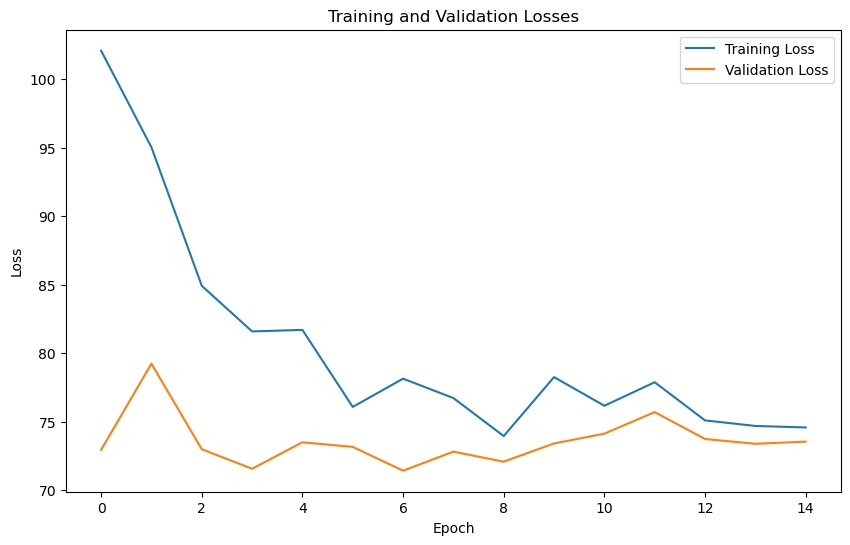

In [40]:
plot_loss(history)

In [ ]:
y_pred = model_xfer.predict(test_image_dataset)
y_pred= y_pred*100000
y_pred = np.squeeze(y_pred)

test_predictions_df = pd.DataFrame(
        {'House ID': test['House ID'],
        'Price': y_pred})

#test_predictions_df.to_csv(
#        f'Kaggle Submissions/{naam_bestand}.csv',
#        index=False)

In [ ]:
tf.keras.utils.plot_model(
    resnet50_model,
    to_file='resnet50_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False)

<b> Voordelen van het gebruik van vooraf getrainde visionmodellen </b>
    
Vooral getrainde visionmodellen hebben verschillende voordelen, zoals bijvoorbeeld:
- Je hebt minder gegevens nodig
- Het gebruikt minder rekenkracht
- Het is nauwkeuriger dan een op maat gebouwd CNN model. (AppMaster. (2023, September 21)). (Fakhry, A. (2020, November 4).)
- Effectieve generalisatie: Doordat het model al getraind is op een bepaalde taak kan het model al snel geschikt worden gemaakt op soortgelijke taken.

(Potter, K., & Karl, L. (2023, September 5).)




### Bevindingen transfer learning <a name='bevindingen_tl'></a>
Het transfer learning model geeft een redelijk goede score:
Mean Squared Error (MSE): 69.69720458984375
Laagst behaalde validatieloss: 71.42872619628906


[Terug naar Inhoudsopgave](#begin)

## Opdracht 5 - Multimodaal model <a name='mm'></a>

#TODO:
Keuze gebruik hyperparameters en strategie bespreken
Keuze aantal epochs uitgelegd


In [43]:
image_size = (224, 224)
batch_size = 32

image_dataset = tf.keras.utils.image_dataset_from_directory(
    'Train',
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size
)

image_file_paths = image_dataset.file_paths

image_uuids = [Path(image_file_path).stem for image_file_path in image_file_paths]

tabular_features = [train2.loc[train2['House ID'] == uuid, ['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude']].values[0] for uuid in image_uuids]

tabular_features_dataset = tf.data.Dataset.from_tensor_slices(tabular_features).batch(batch_size)

labels = [train2.loc[train2['House ID'] == uuid, 'Price'].values[0] / 100000 for uuid in image_uuids]

labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)

final_dataset = tf.data.Dataset.zip((image_dataset, tabular_features_dataset), labels_dataset)

Found 500 files belonging to 1 classes.


In [44]:
test_image_dataset = tf.keras.utils.image_dataset_from_directory(
    'Test',
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size
)

test_image_file_paths = test_image_dataset.file_paths

test_image_uuids = [Path(image_file_path).stem for image_file_path in test_image_file_paths]

test_tabular_features = [test2.loc[test2['House ID'] == uuid, ['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude']].values[0] for uuid in test_image_uuids]
tabular_features_array = np.array(test_tabular_features)
test_images_array = np.concatenate([image.numpy() for image in test_image_dataset])

Found 35 files belonging to 1 classes.


In [45]:
num_batches_train = len(list(final_dataset))
print("Number of batches in final_train_dataset:", num_batches_train)

Number of batches in final_train_dataset: 16


In [46]:
train_dataset_5 = final_dataset.take(12) 
val_dataset_5 = final_dataset.skip(12) 

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_5 = train_dataset_5.cache().shuffle(5).prefetch(buffer_size=AUTOTUNE)
val_dataset_5 = val_dataset_5.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
y_train = np.concatenate([y for x, y in train_dataset_5], axis=0)
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [49]:
#del(model)

#kaggle score 0.56325 // vs_opdracht_5_4.csv

img_input = Input(shape=(224, 224, 3), name='img_input')
x1 = Conv2D(32, (3, 3), activation='relu')(img_input)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(64, (3, 3), activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(128, (3, 3), activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)

tab_input = Input(shape=(5,), name='tab_input')
x2 = Dense(64, activation='relu')(tab_input)
x2 = Dense(128, activation='relu')(x2)

concatenated = concatenate([x1, x2])

x = Dense(256, activation='relu')(concatenated)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

output = Dense(1)(x)

model = Model(inputs=[img_input, tab_input], outputs=output)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005), loss='mape')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input (InputLayer)      [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 222, 222, 32)         896       ['img_input[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d_2[0][0]'] 

In [50]:
early_stopping = EarlyStopping(patience=15)
num_epochs = 20

history = model.fit(train_dataset_5, validation_data=val_dataset_5, class_weight=class_weights_dict, epochs=num_epochs, callbacks=[early_stopping])

Epoch 1/20
12/12 [==============================] - 16s 1s/step - loss: 94472.7500 - val_loss: 106.4197
Epoch 2/20
12/12 [==============================] - 13s 1s/step - loss: 129.6577 - val_loss: 55.8656
Epoch 3/20
12/12 [==============================] - 13s 1s/step - loss: 70.7901 - val_loss: 56.2514
Epoch 4/20
12/12 [==============================] - 14s 1s/step - loss: 67.7960 - val_loss: 53.6278
Epoch 5/20
12/12 [==============================] - 13s 1s/step - loss: 65.3707 - val_loss: 51.0440
Epoch 6/20
12/12 [==============================] - 13s 1s/step - loss: 61.9402 - val_loss: 50.3547
Epoch 7/20
12/12 [==============================] - 14s 1s/step - loss: 60.2964 - val_loss: 55.4094
Epoch 8/20
12/12 [==============================] - 14s 1s/step - loss: 62.4190 - val_loss: 49.8955
Epoch 9/20
12/12 [==============================] - 14s 1s/step - loss: 60.3973 - val_loss: 50.0750
Epoch 10/20
12/12 [==============================] - 14s 1s/step - loss: 61.7055 - val_loss: 53

In [51]:
y_pred = model.predict([test_images_array, tabular_features_array])
y_pred= y_pred*100000
y_pred = np.squeeze(y_pred)
    


test_predictions_df = pd.DataFrame(
        {'House ID': test['House ID'],
        'Price': y_pred})
    

#test_predictions_df.to_csv(
#        f'Kaggle Submissions/vs_opdracht_5_6.csv',
#        index=False)
    

2/2 [==============================] - 0s 35ms/step


In [52]:
#28 maart NKOK toegevoegd#
print("Mean Squared Error (MSE):", history.history['val_loss'][-1])
print("Laagste val_loss:", min(history.history['val_loss']))
### einde toevoeging


Mean Squared Error (MSE): 50.461490631103516
Laagste val_loss: 49.74808120727539


In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='modelmultimodaal.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False)

### Bevindingen Multimodaal model <a name='bevindingen_mm'></a>
Bij dit CNN met L1-regularisatie en batch normalization zijn bij 64 datapunten (batch num_iterations = 2) en 10 epochs  

[Terug naar Inhoudsopgave](#begin)

## Opdracht 6 - Bevindingen <a name='bevindingen'></a>

Het multimodaal model scoorde de laagste Mean Squared Error en de laagste validation loss tot nu toe:
Mean Squared Error (MSE): 50.461490631103516
Laagste val_loss: 49.74808120727539


## ***Bevindingen per onderdeel*** <a name='begin'></a>
[Bevindingen EDA](#bevindingen_eda)

[Bevindingen Fully connected neural network](#bevindingen_fcnn)

[Bevindingen Convolutional neural network](#bevindingen_cnn)

[Bevindingen Transfer learning](#bevindingen_tl)

[Bevindingen Multimodaal model](#bevindingen_mm)

Op basis van de bovenstaande resultaten zien we dat bij deze specifieke modellen en hyperparameters het best presterende model <TODO: vul in...> of <TODO: vul in...> zou kunnen zijn. De prestaties van het  fully functional model wordt . We moeten in ogenschouw nemen dat de resultaten kunnen verschillen op basis van de random die wordt gekozen, of op basis van dat er juist geen random is gekozen. Een voorbeeld ter illustratie vormen de uitslagen van het CNN-model in Bijlage 1.  




[Terug naar Inhoudsopgave](#begin)


## Opdracht 7 - Conclusie en aanbevelingen <a name='conclusie'></a>

In [ ]:
#TODO: conclusie schrijven die het volgende bevat:

#Samenvatting modelleringsproces
#Conclusie gebaseerd op bevindingen
#Aanbeveling die aansluit op de conclusie

[Terug naar Inhoudsopgave](#begin)

## Bronnenlijst <a name='bronnenlijst'></a>

AppMaster. (2023, September 21). Computervisie. van https://appmaster.io/nl/glossary/computervisie

Brownlee, J. (2020, August 20). A Gentle Introduction to the Rectified Linear Unit (ReLU). Machine Learning Mastery. https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

deeplizard. (2017, November 23). Batch Size in a Neural Network explained [Video]. YouTube. https://www.youtube.com/watch?v=U4WB9p6ODjM    

Fakhry, A. (2020, November 4). The Applications and Benefits of a PreTrained Model –– Kaggle’s DogsVSCats. Towards Data Science. Geraadpleegd op 28 maart, 2024, van https://towardsdatascience.com/the-applications-and-benefits-of-a-pretrained-model-kaggles-dogsvscats-50221902c696

Gupta, S. (2023, June 30). The 7 Most Common Machine Learning Loss Functions. Built In National. https://builtin.com/machine-learning/common-loss-functions    
    
Kiang, M. Y. (2003). Neural Networks. In Encyclopedia of Information Systems. IV.A. Fully Vs Partially Connected Networks. Retrieved from [URL]

Krishnamurthy, B. (2024, February 26). An Introduction to the ReLU Activation Function. Built In. https://builtin.com/machine-learning/relu-activation-function
    
Madhugiri, D. (2023, April 6). Visualize Deep Learning Models using Visualkeras. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2023/04/visualize-deep-learning-models-using-visualkeras/    
    
Potter, K., & Karl, L. (2023, September 5). Transfer Learning and Pretrained Models. Retrieved from https://osf.io/xte4p/download/?format=pdf    
    
Wikipedia contributors. (2022, March 28). Batch normalization. In Wikipedia, The Free Encyclopedia. Retrieved March 28, 2022, from https://en.wikipedia.org/wiki/Batch_normalization    






[Terug naar Inhoudsopgave](#begin)

## Bijlage 1

Toen er geen random ingesteld was bij het CNN waren de resultaten (van de val loss) als volgt:

Epoch 1/10
64/64 [==============================] - 234s 4s/step - loss: 5576.4834 - val_loss: 47.1230
Epoch 2/10
64/64 [==============================] - 233s 4s/step - loss: 302.2599 - val_loss: 33.6692
Epoch 3/10
64/64 [==============================] - 230s 4s/step - loss: 102.4257 - val_loss: 29.5851
Epoch 4/10
64/64 [==============================] - 233s 4s/step - loss: 110.4687 - val_loss: 30.5949
Epoch 5/10
64/64 [==============================] - 236s 4s/step - loss: 107.4076 - val_loss: 38.9470
Epoch 6/10
64/64 [==============================] - 232s 4s/step - loss: 88.1527 - val_loss: 27.7405
Epoch 7/10
64/64 [==============================] - 231s 4s/step - loss: 52.3793 - val_loss: 23.3302
Epoch 8/10
64/64 [==============================] - 232s 4s/step - loss: 55.4680 - val_loss: 22.4555
Epoch 9/10
64/64 [==============================] - 235s 4s/step - loss: 37.1687 - val_loss: 23.2327
Epoch 10/10
64/64 [==============================] - 239s 4s/step - loss: 35.8145 - val_loss: 23.3548

En bij random 42 ligt de val_loss beduidend hoger: Epoch 1/10
64/64 [==============================] - 234s 4s/step - loss: 4992.3804 - val_loss: 651.3210
Epoch 2/10
64/64 [==============================] - 232s 4s/step - loss: 530.7753 - val_loss: 220.5642
Epoch 3/10
64/64 [==============================] - 228s 4s/step - loss: 327.4266 - val_loss: 109.9741
Epoch 4/10
64/64 [==============================] - 226s 4s/step - loss: 183.6015 - val_loss: 145.4266
Epoch 5/10
64/64 [==============================] - 226s 4s/step - loss: 177.8286 - val_loss: 78.8311
Epoch 6/10
64/64 [==============================] - 226s 4s/step - loss: 112.9160 - val_loss: 115.7820
Epoch 7/10
64/64 [==============================] - 226s 4s/step - loss: 96.1510 - val_loss: 63.2555
Epoch 8/10
64/64 [==============================] - 231s 4s/step - loss: 101.4236 - val_loss: 68.7640
Epoch 9/10
64/64 [==============================] - 238s 4s/step - loss: 134.0570 - val_loss: 70.3438
Epoch 10/10
49/64 [=====================>........] - ETA: 54s - loss: 77.6230  (Opmerking: Deze run was afgebroken)

En bij een ingestelde random van 12 dit:




In [ ]:
[Terug naar Inhoudsopgave](#begin)